# Rappi Challenge Data Engineer
**Developer**: COLLANTE, Gerardo

# Librerías

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from humanize import intword
import missingno as msno
import matplotlib.ticker as mtick

DEBUG = True
style = 'bmh'
plt.style.use(style)

# Carga de datos

In [144]:
DATADIR = 'data'
FILENAME = 'challenge_orders.csv'
PATH = os.path.join(DATADIR, FILENAME)

In [145]:
df = pd.read_csv(PATH, index_col=0, parse_dates=['CREATED_AT'])

## Comprobación de valores faltantes

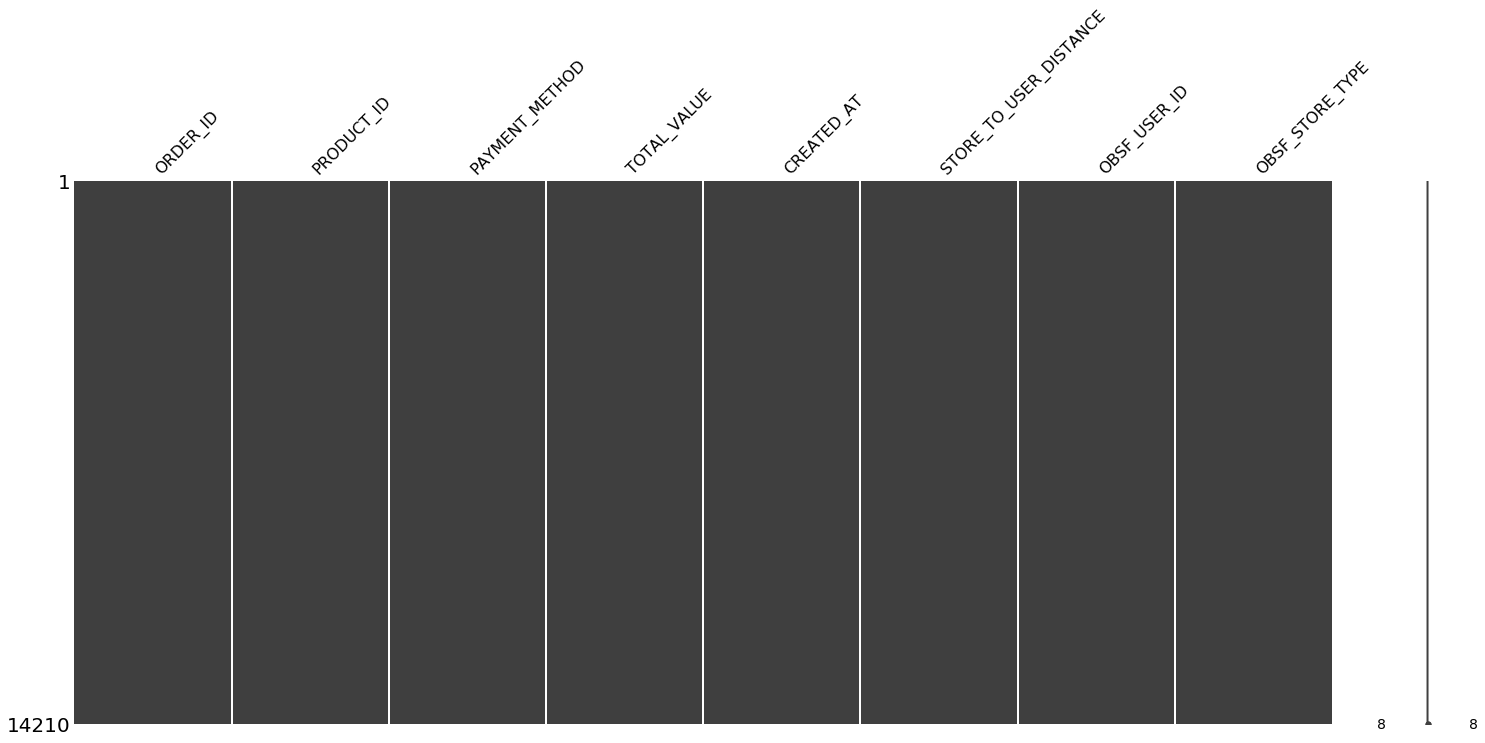

In [146]:
msno.matrix(df)

## Preprocesamiento

In [147]:
df.rename(columns={'ORDER_ID':'order', 
                   'PRODUCT_ID':'product', 
                   'PAYMENT_METHOD':'pay', 
                   'TOTAL_VALUE':'total', 
                   'CREATED_AT':'created', 
                   'STORE_TO_USER_DISTANCE':'dist', 
                   'OBSF_USER_ID':'user', 
                   'OBSF_STORE_TYPE':'store'}, inplace=True)
df.total = df.total.astype(int)
df.dist = df.dist.astype(int)

# Necesidades de negocio

In [479]:
import requests

APP_ID = 'd2847e56a8474a9fb4416b519b1447ce'
symbol = 'COP'
pretty = 'true'
date = '2021-06-01'
url = f'https://openexchangerates.org/api/historical/{date}.json?app_id={APP_ID}&symbols={symbol}&prettyprint={pretty}'
response = requests.get(url)
usd = response.json()['rates'][symbol]
print(usd)

3709.719348


In [482]:
def get_usd_cop(date:str):
    url = f'https://openexchangerates.org/api/historical/{date}.json?app_id={APP_ID}&symbols={symbol}&prettyprint={pretty}'
    try:
        response = requests.get(url)
        usd = response.json()['rates'][symbol]
    except:
        usd = np.nan
        print('Sucedio un error')
    return float(usd)

In [497]:
dates=df.created.apply(lambda x: x.strftime('%Y-%m-%d')).unique()

column_names = ["date", "usd"]
usd_df = pd.DataFrame(columns = column_names)

In [507]:
for index, date in enumerate(dates):
    try: 
        usd_df.loc[index,'usd']
    except:
        usd_df.loc[index]=[date,get_usd_cop(date)]

In [508]:
usd_df.set_index('date')

,usd
date,
2019-04-15,3122.942901
2019-04-16,3144.438907
2019-04-17,3167.129978


In [509]:
df

,order,product,pay,total,created,dist,user,store
0,35394843,2090144731,cash,1940,2019-04-15 13:40:19+00:00,488,8540,5
1,35419116,2090144731,cc,8900,2019-04-16 20:54:24+00:00,4761,3990,14
2,35404241,2090144731,cash,150,2019-04-15 21:12:49+00:00,3141,19052,5
3,35405366,2090144731,cash,400,2019-04-15 21:58:28+00:00,3070,16978,14
4,35406544,2090144731,cash,9580,2019-04-15 23:36:01+00:00,1210,9521,5
5,35421204,2090144731,cash,13070,2019-04-16 22:55:45+00:00,1210,9521,5
6,35415936,2090149053,cc,10300,2019-04-16 19:14:37+00:00,2605,846,33
7,35412415,2090149059,cc,12200,2019-04-16 15:40:21+00:00,4577,4403,33
8,35414692,2090149059,cc,8400,2019-04-16 18:16:24+00:00,4848,18693,48
9,35412415,2090149073,cc,12200,2019-04-16 15:40:21+00:00,4577,4403,33


In [515]:
usd_df.set_index('date', inplace=True)#

In [523]:
print(usd_df.loc['2019-04-15'].usd)

3122.942901


In [525]:
def usd_cop(x):
    value = usd_df.loc[x].usd
    return value

In [529]:
%%time

df['usd_cop'] = df.created.apply(lambda x: usd_cop(x.strftime('%Y-%m-%d')))
df.total = df.total/df.usd_cop

CPU times: user 8.38 s, sys: 191 ms, total: 8.57 s
Wall time: 8.58 s


In [530]:
df.total

0         0.621209
1         2.830394
2         0.048032
3         0.128084
4         3.067619
5         4.156544
6         3.275624
7         3.879865
8         2.671383
9         3.879865
10        1.240285
11        0.858659
12        0.861367
13        0.000000
14        0.000000
15        8.666093
16        4.915236
17        2.497644
18        4.573153
19        2.497644
20        2.497644
21        0.416274
22        4.054777
23        5.043320
24        6.408138
25        0.605198
26        1.869968
27        0.000000
28        2.779510
29        2.989405
           ...    
14180     0.829346
14181     2.187040
14182     2.871737
14183     1.268907
14184     3.561844
14185     1.259816
14186     3.512712
14187     2.692973
14188     1.738745
14189     1.615551
14190     0.505655
14191     7.124690
14192     2.555282
14193     3.720849
14194     3.067619
14195     2.820853
14196     5.043320
14197     5.043320
14198     2.941701
14199     2.393334
14200     2.393334
14201     1.

## Ranking por tipo de tienda que más dólares generó
Se agrupó por ```store```, sumando sus valores y luego ordenandolos de mayor a menor.

In [531]:
def get_revenue_per_store(df:pd.DataFrame)->pd.DataFrame:
    revenue = df.groupby(by='store').sum().total.sort_values(ascending=False).to_frame() \
    .rename(columns={'total':'revenue'})
    return revenue

In [532]:
revenue = get_revenue_per_store(df)

In [533]:
revenue.head()

,revenue
store,
1,64438.768164
13,6861.660906
9,5845.515493
4,1856.927791
5,1370.054336


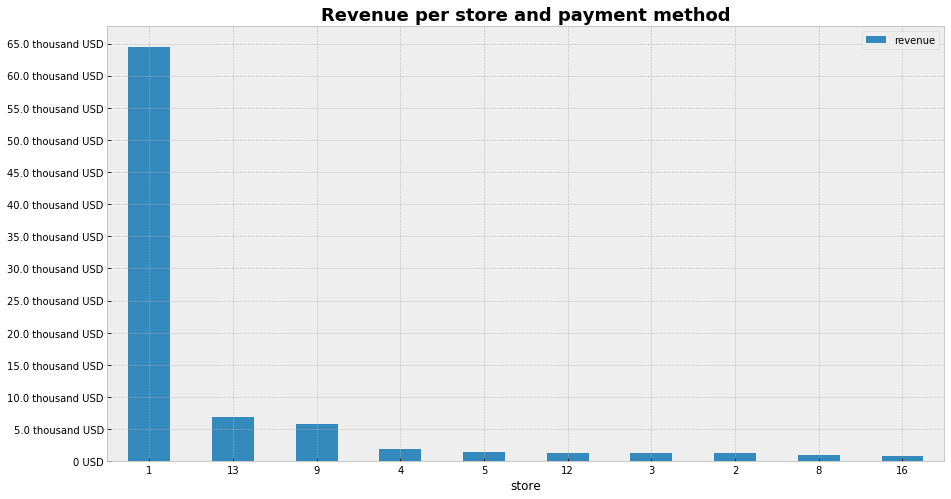

In [571]:
stores_showed = 10
figsize = (15,8)
step = 5000
min_ = float(revenue.min())
max_ = float(revenue.max()+step)
# Draw plot
fig = revenue.nlargest(stores_showed, 'revenue').plot(kind='bar', 
                                                      stacked=True, 
                                                      figsize=figsize)

# Decorations
fig.set_yticks(np.arange(min_, max_, step))
y_ticks = [f'{intword(x)} USD' for x in list(fig.get_yticks())]
fig.set_title('Revenue per store and payment method', fontdict={'size':18, 'weight':'bold'})
fig.set_yticklabels(y_ticks)
fig.tick_params(labelrotation=0)
plt.show()

## Proporción por medio de pago
Primero se filtro por medio de pago, *i.e.* ```pay``` y luego se agrupó por ```store``` calculando la suma total. Este procedimiento se debe realizar dos veces, una por método de pago, pero con la función ```get_revenue_by_pay_method``` es posible obtener este cálculo extendiendolo a $n$ métodos de pago.

### Método 1

In [535]:
def get_revenue_by_pay_method(df:pd.DataFrame, pay_method:str)->pd.DataFrame:
    # Filter and group-by
    gb = df[df.pay==pay_method].groupby(by='store').sum().total
    # Transform to DataFrame
    revenue_per_pay_method = gb.to_frame().rename(columns={'total':f'revenue_{pay_method}'})
    # Match total and revenue per pay method
    return revenue_per_pay_method

In [536]:
# Get revenue per payment method
revenue_cc = get_revenue_by_pay_method(df,'cc')
revenue_cash = get_revenue_by_pay_method(df,'cash')

In [537]:
# Concat dfs
my_df = pd.concat([revenue, revenue_cc, revenue_cash], axis=1).fillna(0).astype(int)

In [538]:
# Revenue per df
my_df['pct_cc'] = my_df.revenue_cc/my_df.revenue
my_df['pct_cash'] = my_df.revenue_cash/my_df.revenue

In [539]:
my_df.fillna(0, inplace=True)

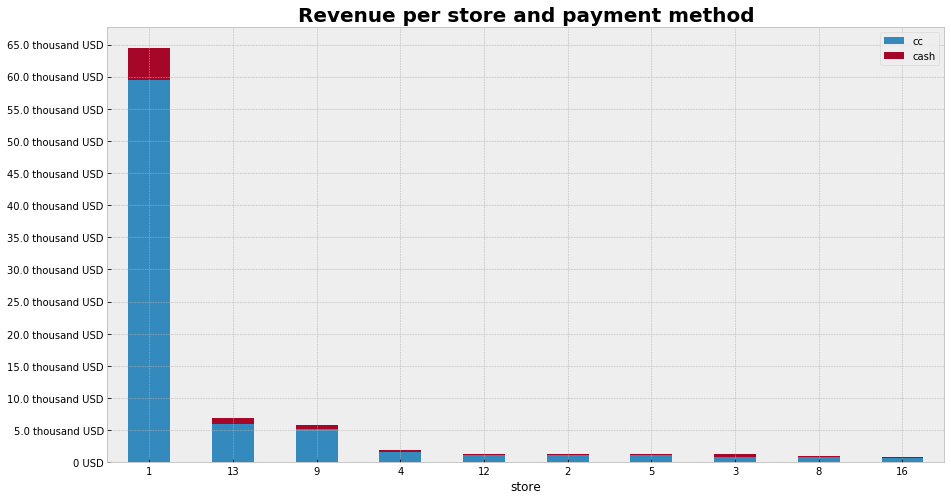

In [573]:
stores_showed = 10
figsize = (15,8)
step = 5000
min_ = float(revenue.min())
max_ = float(revenue.max()+step)
# Draw plot
fig = my_df.loc[:,'revenue_cc':'revenue_cash'].nlargest(stores_showed, 'revenue_cc').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=figsize)

# Decorations
fig.set_yticks(np.arange(min_, max_, step))
y_ticks = [f'{intword(x)} USD' for x in list(fig.get_yticks())]
fig.set_yticklabels(y_ticks)
fig.set_title('Revenue per store and payment method', fontdict={'size':20, 'weight':'bold'})
fig.legend(['cc','cash'])
fig.tick_params(labelrotation=0)
plt.show()

### Método 2

In [574]:
def get_pct_by_pay_method(df:pd.DataFrame, pay_method:str)->pd.DataFrame:
    # Filter and group-by
    revenue_per_store = get_revenue_per_store(df)
    revenue_per_store_filtered = df[df.pay==pay_method].groupby(by='store').sum().total.to_frame() \
    .rename(columns={'total':f'revenue_{pay_method}'})
    # Match total and revenue per pay method
    temp_df = pd.concat([revenue_per_store, revenue_per_store_filtered], axis=1).fillna(0)
    # Show temporal df
    if DEBUG:
        display(temp_df.head(10))
    pct_by_pay_method = (temp_df[f'revenue_{pay_method}']/temp_df['revenue']).to_frame() \
    .rename(columns={0:f'pct_{pay_method}'})
    return pct_by_pay_method

In [575]:
pct_by_pay_cc = get_pct_by_pay_method(df,'cc')
pct_by_pay_cash = get_pct_by_pay_method(df,'cash')

,revenue,revenue_cc
store,,
1,64438.768164,59460.093634
2,1234.247330,1065.342014
3,1277.482395,890.616774
4,1856.927791,1588.810256
5,1370.054336,1064.200736
6,46.649949,33.060879
7,1.217121,1.217121
8,987.000437,836.005140
9,5845.515493,5161.676677


,revenue,revenue_cash
store,,
1,64438.768164,4978.674530
2,1234.247330,168.905316
3,1277.482395,386.865621
4,1856.927791,268.117535
5,1370.054336,305.853600
6,46.649949,13.589070
7,1.217121,0.000000
8,987.000437,150.995297
9,5845.515493,683.838816


In [576]:
# Create ranking
ranking_df = pd.concat([revenue, pct_by_pay_cc, pct_by_pay_cash], axis=1).fillna(0)

In [577]:
ranking_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,pct_cc,pct_cash
store,,,
1,64438.768164,0.922738,0.077262
13,6861.660906,0.862659,0.137341
9,5845.515493,0.883015,0.116985
4,1856.927791,0.855612,0.144388
5,1370.054336,0.776758,0.223242
12,1353.521340,0.836998,0.163002
3,1277.482395,0.697166,0.302834
2,1234.247330,0.863151,0.136849
8,987.000437,0.847016,0.152984


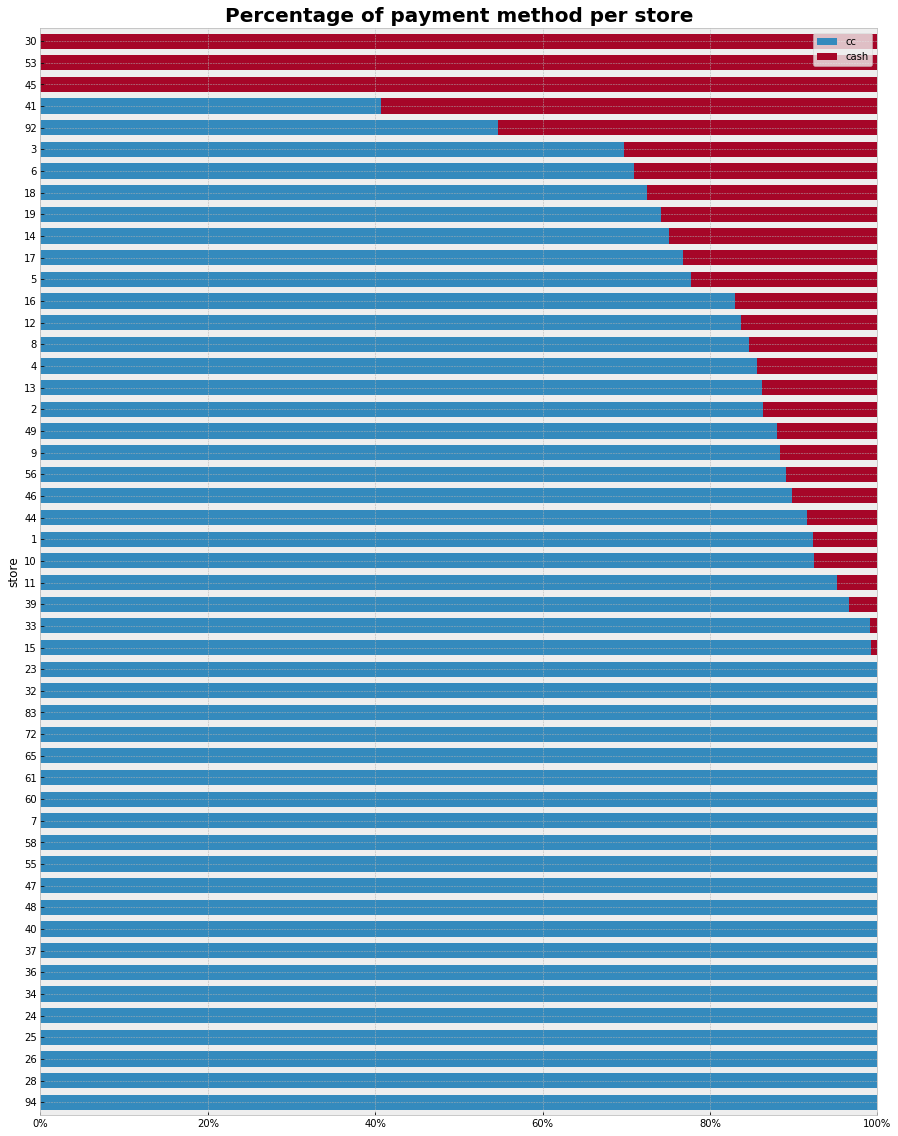

In [578]:
# Draw plot
plot_df = ranking_df[(ranking_df.pct_cc>0) | (ranking_df.pct_cash>0)]
order_by = 'cash'
fig = plot_df.loc[:,'pct_cc':'pct_cash'].sort_values(by=f'pct_{order_by}').plot(kind='barh',
                                                                                stacked=True,
                                                                                figsize=(15,20), 
                                                                                grid=True, 
                                                                                width=0.7)

# Decorations
fig.set_title('Percentage of payment method per store', fontdict={'size':20, 
                                                                  'weight':'bold'})
fig.legend(['cc','cash'])
fig.tick_params(labelrotation=0)
fig.set_xlim(0,1)
fig.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## AOV
El ```aov``` (valor medio de la orden) se calcula de la siguiente manera:
$$\texttt{AOV} = \frac{\texttt{revenue}}{\texttt{orders}}$$

In [579]:
def get_orders_per_store(df:pd.DataFrame)->pd.DataFrame:
    orders = df.groupby(by='store').count().order.rename('orders').to_frame()
    return orders

In [580]:
def get_aov_per_store(df:pd.DataFrame)->pd.DataFrame:
    orders = get_orders_per_store(df)
    revenue = get_revenue_per_store(df)
    temp_df = pd.concat([orders, revenue], axis=1)
    if DEBUG:
        #display(temp_df)
        pass
    aov = (temp_df.revenue/temp_df.orders).to_frame().rename(columns={0:'aov'})
    return aov

In [581]:
aov = get_aov_per_store(df)

In [582]:
ranking_df = ranking_df.join(aov)

In [583]:
ranking_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,pct_cc,pct_cash,aov
store,,,,
1,64438.768164,0.922738,0.077262,9.939653
13,6861.660906,0.862659,0.137341,5.484941
9,5845.515493,0.883015,0.116985,4.330011
4,1856.927791,0.855612,0.144388,2.852424
5,1370.054336,0.776758,0.223242,1.856442
12,1353.521340,0.836998,0.163002,1.744229
3,1277.482395,0.697166,0.302834,2.718048
2,1234.247330,0.863151,0.136849,3.438015
8,987.000437,0.847016,0.152984,1.258929


In [584]:
# Clear empty values
ranking_df = ranking_df[ranking_df.aov>0]

In [585]:
# Compute z-score
x = ranking_df.aov
ranking_df['aov_z'] = (x - x.mean())/x.std()
ranking_df['colors'] = ['red' if x < 0 else 'green' for x in ranking_df['aov_z']]
ranking_df.sort_values('aov', inplace=True)

In [586]:
# Set store as index
ranking_df.index = ranking_df.index.astype(str)

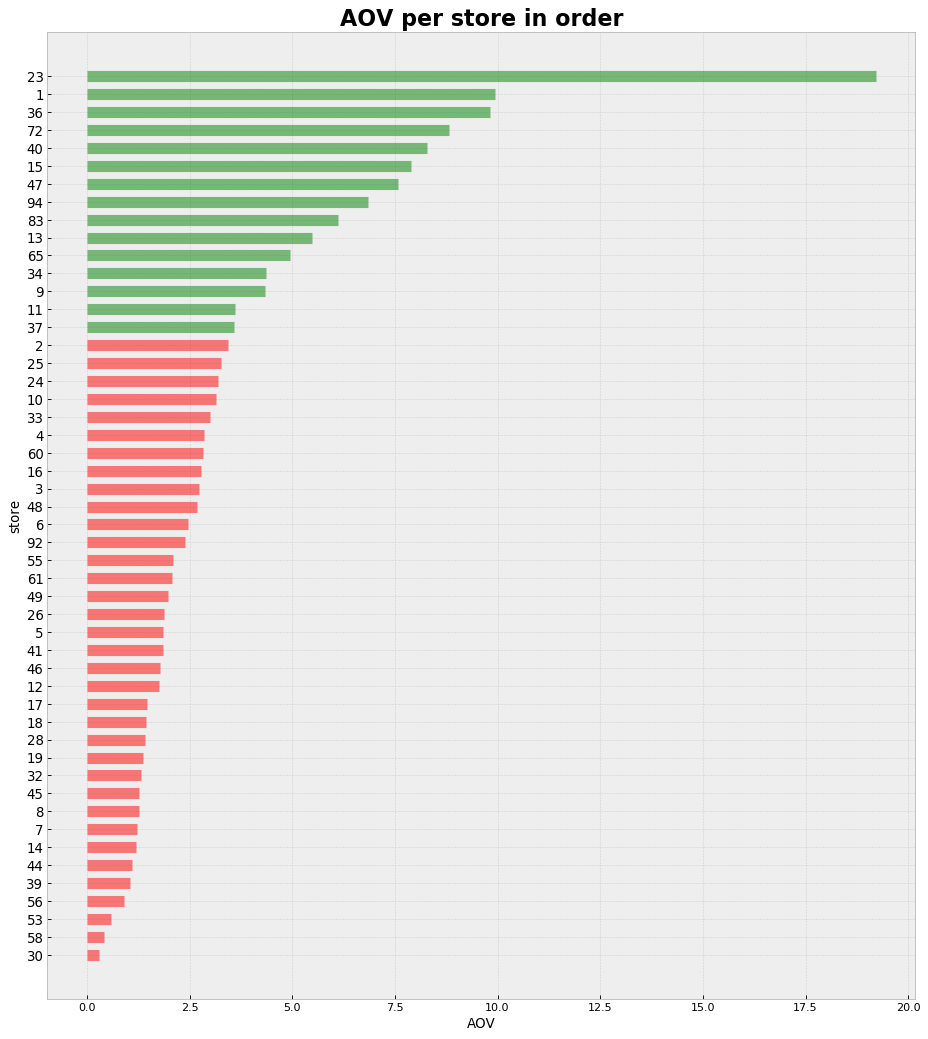

In [587]:
# Draw plot
plt.figure(figsize=(14,16), dpi= 80)
plt.hlines(y=ranking_df.index, 
           xmin=0, 
           xmax=ranking_df.aov, 
           color=ranking_df.colors, 
           alpha=0.5, 
           linewidth=10)

# Decorations
plt.gca().set(ylabel='store', xlabel='AOV')
plt.yticks(ranking_df.index, fontsize=12)
plt.title('AOV per store in order', 
          fontdict={'size':20, 
                    'weight':'bold'})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [588]:
ts = df.set_index(df.created)

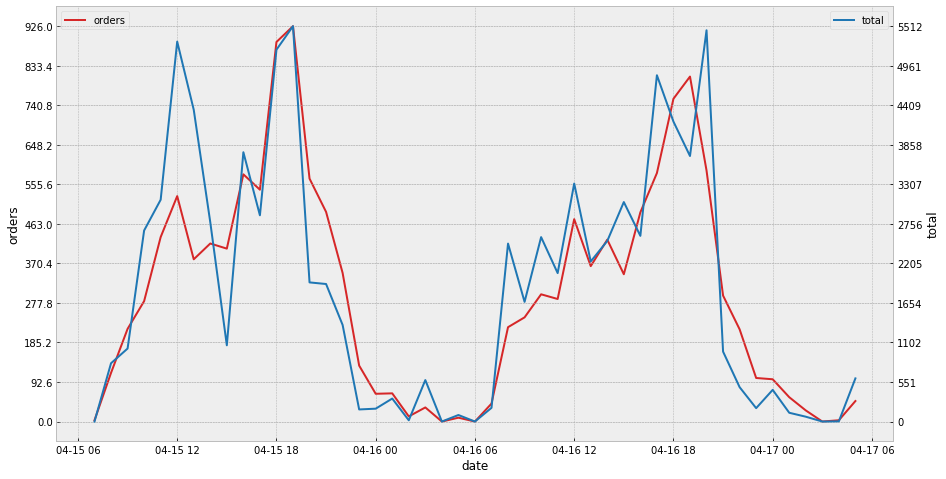

In [618]:
# Compute df to plot
t = '1H'
ts_orders = ts.resample(t).order.count().to_frame()
ts_total = ts.resample(t).total.sum().to_frame()

# Variables
steps = 10
ax1_yticks=np.linspace(ts_orders.min(), ts_orders.max(), steps+1)
ax2_yticks=np.linspace(ts_total.min(), ts_total.max(), steps+1)
ax1_color='tab:red'
ax2_color='tab:blue'

# Draw plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(ts_orders, color=ax1_color, label='orders')

# Decorate

ax1.set_xlabel('date')
ax1.set_ylabel('orders')
ax1.tick_params(axis='y')
ax1.set_yticks(ax1_yticks)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Draw plot
ax2.plot(ts_total, color=ax2_color, label='total')

# Decorate
ax2.set_ylabel('total')
ax2.set_yticks(ax2_yticks)
ax2.legend(loc='upper right')

plt.show()

In [623]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [600]:
steps = 10
np.linspace(ts_orders.min(), ts_orders.max(), steps+1)

array([[  0. ],
       [ 50.1],
       [100.2],
       [150.3],
       [200.4],
       [250.5],
       [300.6],
       [350.7],
       [400.8],
       [450.9],
       [501. ]])

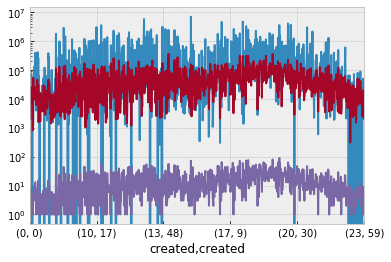

In [56]:
hour_df = pd.concat([ts.groupby([ts.index.hour, ts.index.minute])[['total','dist']].sum(), \
                     ts.groupby([ts.index.hour, ts.index.minute])[['order']].count()], axis=1)

hour_df.total.plot(logy=True)
hour_df.dist.plot()
hour_df.order.plot()